Performing sentiment analysis on Reddit's subreddits

This step involves importing the neccessary libraries to perform the analysis.

We are using the following:
1. Praw: This is being used to scrape data off of Reddit using my API credentials.
2. Pandas: For easier handling of datasets.
4. Vader: This is a pretrained model using to perform the analysis.
5. Transformers: This library provides us with BERT, another model that we are going to perform the analysis with.
6. Matplotlib: This will be used to visualize the data.

In [1]:
import praw
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline
import matplotlib.pyplot as plt


The following are my API credentials, these allow scraping of data, keeping in line with reddit's terms and conditions.

In [2]:
reddit = praw.Reddit(
    client_id='D25w5GQ_Bmaa9UtmiC0mYw',
    client_secret='WWzX2gD-m2aW3Prsm8cOfkunQSkKsA',
    user_agent='ULPTthrowaway2313212'
)

This is VADER being used to perform sentiment analysis, we first scrape the neccessary data and then analyse and visualize the result for easier understanding. It takes the name of a subreddit as an input. 

Scraping r/moviecritic...
Performing sentiment analysis...
Visualizing results...


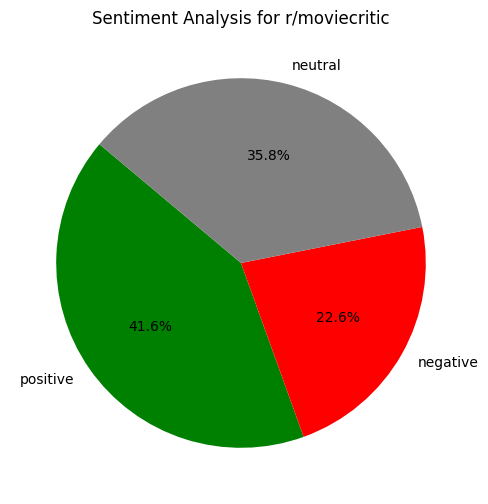

Sentiment Distribution:
Positive: 15318
Negative: 8327
Neutral: 13162


In [3]:
def scrape_reddit(subreddit_name, limit=500):
    subreddit = reddit.subreddit(subreddit_name)
    posts = []
    
    for post in subreddit.hot(limit=limit):  # Get posts sorted by 'hot'
        post_comments = []
        post.comments.replace_more(limit=0)  # Avoid fetching too many nested comments
        
        for comment in post.comments.list():
            post_comments.append(comment.body)
        
        posts.append({'title': post.title, 'comments': post_comments})
    
    return posts

def analyze_sentiment(posts):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_results = {'positive': 0, 'negative': 0, 'neutral': 0}
    
    for post in posts:
        for text in [post['title']] + post['comments']:  # Analyze both titles and comments
            sentiment = analyzer.polarity_scores(text)
            
            if sentiment['compound'] >= 0.05:
                sentiment_results['positive'] += 1
            elif sentiment['compound'] <= -0.05:
                sentiment_results['negative'] += 1
            else:
                sentiment_results['neutral'] += 1
    
    return sentiment_results

def visualize_results(sentiment_results, subreddit_name):
    labels = sentiment_results.keys()
    sizes = sentiment_results.values()
    colors = ['green', 'red', 'gray']
    
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
    plt.title(f'Sentiment Analysis for r/{subreddit_name}')
    plt.savefig("results/plots/VADER-PIE.png")
    plt.show()
    
def main():
    subreddit_name = input("Enter a subreddit: ")
    print(f"Scraping r/{subreddit_name}...")
    posts = scrape_reddit(subreddit_name)
    
    print("Performing sentiment analysis...")
    sentiment_results = analyze_sentiment(posts)
    
    print("Visualizing results...")
    visualize_results(sentiment_results, subreddit_name)
    
    print("Sentiment Distribution:")
    for key, value in sentiment_results.items():
        print(f"{key.capitalize()}: {value}")

if __name__ == "__main__":
    main()


This here is a pre-trained version of BERT being used to perform the sentiment analysis, it also scrapes data analyzing and visualizing it, taking the name of a subreddit as an input.

Device set to use cpu


Scraping r/moviecritic...
Performing sentiment analysis...
Visualizing results...


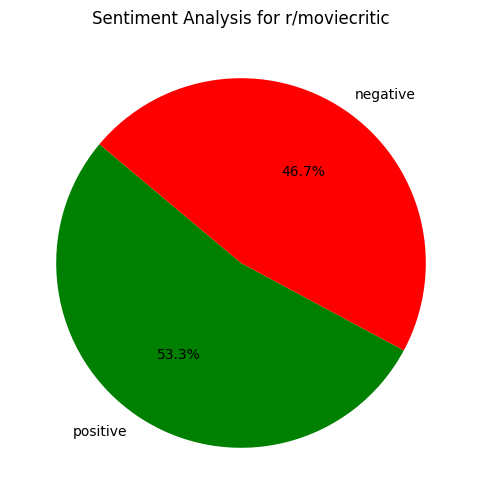

Sentiment Distribution:
Positive: 19345
Negative: 16971


In [4]:
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

def scrape_reddit(subreddit_name, limit=500):
    subreddit = reddit.subreddit(subreddit_name)
    posts = []
    
    for post in subreddit.hot(limit=limit):
        post.comments.replace_more(limit=0)  # Ignore long nested threads
        for comment in post.comments.list():
            posts.append(comment.body)
    
    return posts

def analyze_sentiment(comments):
    results = {"positive": 0, "negative": 0}
    
    for comment in comments:
        sentiment = sentiment_pipeline(comment, truncation=True, max_length=512)[0]  # Run BERT model
        label = sentiment['label'].lower()
        if label in results:
            results[label] += 1
    
    return results

def visualize_results(results, subreddit_name):
    labels = results.keys()
    sizes = results.values()
    colors = ['green', 'red']
    
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
    plt.title(f'Sentiment Analysis for r/{subreddit_name}')
    plt.savefig("results/plots/BERT-PIE.png")
    plt.show()
    

def main():
    subreddit_name = input("Enter a subreddit: ")
    print(f"Scraping r/{subreddit_name}...")
    comments = scrape_reddit(subreddit_name)
    
    print("Performing sentiment analysis...")
    sentiment_results = analyze_sentiment(comments)
    
    print("Visualizing results...")
    visualize_results(sentiment_results, subreddit_name)
    
    print("Sentiment Distribution:")
    for key, value in sentiment_results.items():
        print(f"{key.capitalize()}: {value}")

if __name__ == "__main__":
    main()
